# Afternoon: Introduction to Spatial Analysis

Now that we've learned the basics of autocorrelation, we're ready to extend the concept to multiple dimensions. We'll see that spatial dimensions are a direct generalization of temporal dimension, and the concept of $lag$ carries over analogously.

First we import the required packages. Again we also have to load the required R packages using `importr`.

In [1]:
#-- Import Required Python Packages
import numpy as np
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
import scipy.spatial
import scipy.linalg

#-- Import R packages in Python
r = robjects.r
nlme = importr('nlme')
stats = importr('stats')

### CAN'T IMPORT THE FOLLOWING.. fix later
#fields = importr('fields')
#geoR = importr('geoR')
#colorRamps = importr('colorRamps')

# Simulate spatially correlated data

Here we use an exponential covariance matrix which closely approximates the autoregressive model. We do this because it is more commonly used in software packages for numerical reasons. The approximation is $\alpha \approx e^{-r}$, where $r$ is referred to as the 'decorrleation parameter'.

In [2]:
# two column matrix with all pair-wise coordinates
M = np.array(np.meshgrid(range(1,31), range(1,31))).reshape(2, 30**2).T 
n = len(M)                                              # number of pairs
D_upper_triangle = scipy.spatial.distance.pdist(M)      # Upper triangle distance matrix
D = scipy.spatial.distance.squareform(D_upper_triangle) # convert to square form distance matrix
r = 0.1                                                 # decorrelation parameter
s = 10                                                  # variance
S = s**2*np.exp(-r*D)                                   # construct covariance matrix based on distance
L = scipy.linalg.cho_factor(S,lower=True)               # Cholesky factorization of the covariance matrix
Si = scipy.linalg.cho_solve(L,np.eye(S.shape[0]))       # Use factorization to efficiently find S^(-1)
Li = np.linalg.inv(L[0])                                # inverse of lower triangle Cholesky matrix

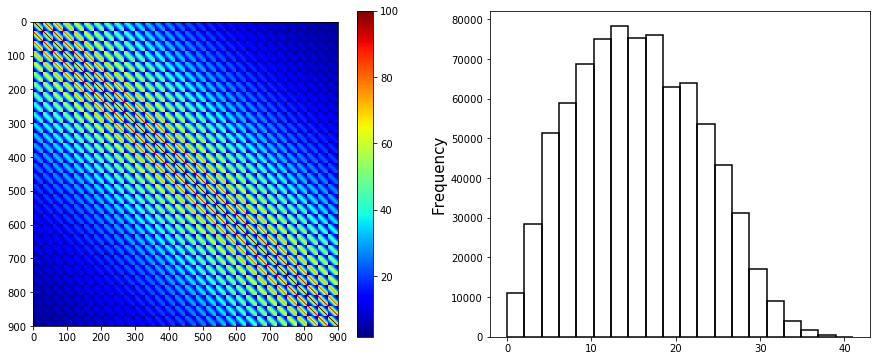

In [3]:
fig, ax = plt.subplots(1,2,figsize=(15,6))                              # Set up figure and subplots
corr_fig = ax[0].imshow(S,cmap='jet')                                   # visualize the covariance matrix
cbar = fig.colorbar(corr_fig,ax=ax[0])                                  # Add colorbar
ax[1].hist(D.flatten(),20,edgecolor='k',facecolor='none',linewidth=1.5) # make a histogram of the pair-wise distances
ax[1].set_ylabel('Frequency',fontsize=15)
plt.show()

** QUESTION: WHY ARE THERE SMALL SQUARES EACH WITH A DECAYING AUTOCORRELATIO PATTERN? ** 

Apply correlation structure to random data.
Note the product of random noise and the lower triangular Choleskly matrix $L$ (i.e. $S=LL^T$) produces the correlation structure of the origina covariance matrix:

Let $x_0$ be a matrix of random uncorrelated values with mean 0 and unit variance (i.e. $E(x_0x_0^T)=I$), and $x = Lx_0$.
Then the covariance of $x$ is 

$E(xx^T) = E((Lx_0)(Lx_0)^T) = E(Lx_0x_0^TL^T) = LE(x_0x_0^T)L^T = LIL^T = LL^T = S$

which is the original covariance matrix with the correlation structure.

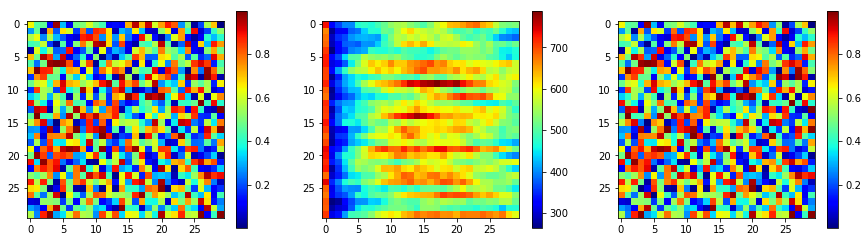

In [11]:
x0 = np.random.rand(n,n)#random nxn matrix
x = np.dot(x0,L[0])     #transform the random data by the factored covariance matrix to generate spatial correlation
x00 = np.dot(x,Li)      #transform back to random data by multiplying by the inverse of the factored covariance matrix
#-- plot
fig, ax = plt.subplots(1,3,figsize=(15,4))     # Set up figure and subplots
x0_fig = ax[0].imshow(x0[:30,:30],cmap='jet')  # Show original random matrix
fig.colorbar(x0_fig,ax=ax[0])                  # Add colorbar
x_fig = ax[1].imshow(x[:30,:30],cmap='jet')    # Show transformed random data with spatial correlation
fig.colorbar(x_fig,ax=ax[1])                   # Add colorbar
x00_fig = ax[2].imshow(x00[:30,:30],cmap='jet')# Show correlated data transformed back to random data
fig.colorbar(x00_fig,ax=ax[2])                 # Add colorbar
plt.show()

# Spatial Interpolation